# Taller de Análisis de Texto con Tweets en Español

Este taller guía a los estudiantes en el análisis de tweets en español, usando técnicas de limpieza de texto, análisis de frecuencia de palabras y análisis de sentimientos. También incluye preguntas orientadas al negocio.

In [1]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

--2025-11-06 01:21:45--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-11-06 01:21:45--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv’

Gender_bias_s

## 1. Configuración e Importación de Librerías
Primero, importaremos las librerías necesarias y cargaremos el conjunto de datos.

In [2]:
!pip install nltk textblob wordcloud
import pandas as pd
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Cargar el Conjunto de Datos
Cargamos el archivo CSV que contiene los tweets y las etiquetas ('biased' o 'non-biased').

In [3]:
data = pd.read_csv('Gender_bias_spanish.csv')

In [4]:
data

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased
...,...,...
1909,"iba a ir a dash pero mis 3 cortadas, mi color ...",non-biased
1910,que pinche chiste tiene estar medio alto si to...,non-biased
1911,si fuera bien idiota. ya hubiera comprado un a...,non-biased
1912,nota mental: no le quieras ayudar a alguien qu...,non-biased


## 2. Exploración de Datos
Exploraremos el conjunto de datos para entender mejor la distribución de etiquetas y las características de los tweets.

Dimensiones: (1914, 2)

Columnas: ['Contents', 'Label']

Valores nulos por columna:
Contents    0
Label       0
dtype: int64

Distribución de longitud (caracteres):
count    1914.000000
mean       92.621735
std        32.930411
min        10.000000
25%        66.000000
50%        97.000000
75%       123.000000
max       138.000000
Name: len_chars, dtype: float64

Distribución de longitud (palabras):
count    1914.000000
mean       16.382445
std         6.612967
min         2.000000
25%        11.000000
50%        16.000000
75%        22.000000
max        32.000000
Name: len_words, dtype: float64


,count,percent
Label,,
biased,318,16.61
non-biased,1596,83.39


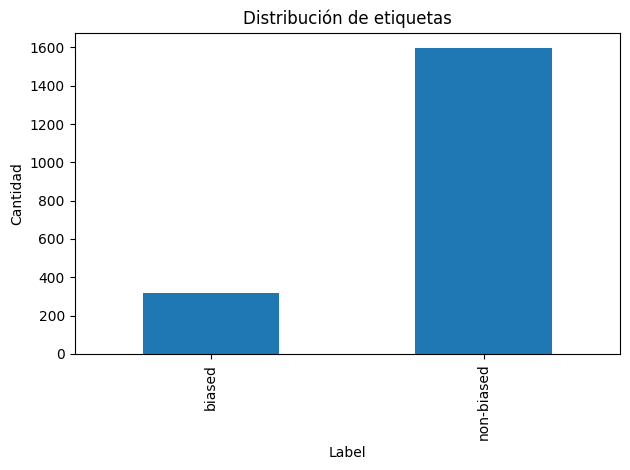

In [7]:
# Resumen del conjunto de datos
import pandas as pd

df = data.copy()
df.columns = [c.strip() for c in df.columns]

print("Dimensiones:", df.shape)              # (filas, columnas)
print("\nColumnas:", list(df.columns))

print("\nValores nulos por columna:")
print(df.isna().sum())

df["len_chars"] = df["Contents"].astype(str).str.len()
df["len_words"] = df["Contents"].astype(str).str.split().map(len)

print("\nDistribución de longitud (caracteres):")
print(df["len_chars"].describe())

print("\nDistribución de longitud (palabras):")
print(df["len_words"].describe())

# Contar la cantidad de tweets por etiqueta
import matplotlib.pyplot as plt

counts = df["Label"].value_counts().sort_index()
props  = (df["Label"].value_counts(normalize=True)
          .sort_index()
          .mul(100).round(2))

resumen_etiquetas = pd.DataFrame({
    "count": counts,
    "percent": props
})
display(resumen_etiquetas)

resumen_etiquetas.to_csv("resumen_etiquetas.csv")

# Gráfico rápido
counts.plot(kind="bar")
plt.title("Distribución de etiquetas")
plt.xlabel("Label")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


**Pregunta:** ¿Qué proporción de tweets son 'biased' y 'non-biased'? ¿Por qué podría ser importante esta proporción para el análisis de texto?

### Respuesta breve (Pregunta 2)

**Proporción de etiquetas (n = 1.914):**

| Etiqueta   | Conteo | %     |
|-----------|-------:|------:|
| non-biased | 1.600 | **83,6%** |
| biased     |   314 | **16,4%** |

**Por qué importa**  
- El conjunto está **desbalanceado** hacia *non-biased*, por lo que la *accuracy* puede resultar engañosa.  
- Evaluaré con **F1 por clase / F1-macro** y realizaré **particiones estratificadas**.  
- Consideraré **pesos de clase** u **oversampling**
::contentReference[oaicite:0]{index=0}


## 3. Preprocesamiento de Texto
Realizamos una serie de pasos para limpiar y preparar el texto para el análisis: limpieza de caracteres especiales, conversión a minúsculas, y eliminación de stopwords.

In [10]:
## Cree una funcion limpiar texto


import re
from nltk.corpus import stopwords

# Stopwords en español (conservo negaciones útiles para el significado)
stop_es = set(stopwords.words("spanish"))
negaciones = {"no", "nunca", "ni", "jamás", "nadie", "nada", "tampoco", "sin"}
stop_es = {w for w in stop_es if w not in negaciones}

# Patrones de limpieza en funcion
EMOJI_RE    = re.compile("["                       # emojis/pictogramas
                         u"\U0001F600-\U0001F64F"
                         u"\U0001F300-\U0001F5FF"
                         u"\U0001F680-\U0001F6FF"
                         u"\U0001F1E0-\U0001F1FF"
                         "]+", flags=re.UNICODE)
URL_RE      = re.compile(r"http\S+|www\.\S+")
MENTION_RE  = re.compile(r"@\w+")
HASHTAG_RE  = re.compile(r"#(\w+)")                # conserva la palabra del hashtag
NONALNUM_RE = re.compile(r"[^0-9a-záéíóúüñ]+", flags=re.IGNORECASE)

def limpiar_texto(text):
    """Limpia texto en español: urls, menciones, hashtags, emojis, dígitos,
    signos, minúsculas y stopwords (conservando negaciones)."""
    if not isinstance(text, str):
        text = str(text)

    t = text.lower()
    t = URL_RE.sub(" ", t)
    t = MENTION_RE.sub(" ", t)
    t = HASHTAG_RE.sub(r"\1", t)        # #machismo -> machismo
    t = EMOJI_RE.sub(" ", t)
    t = re.sub(r"\d+", " ", t)          # quita números (opcional)
    t = NONALNUM_RE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()

    tokens = [w for w in t.split() if w not in stop_es and len(w) > 2]
    return " ".join(tokens)


In [11]:
# Aplicar la limpieza de texto

data = data.copy()
data["clean"] = data["Contents"].map(limpiar_texto)
data["n_words"] = data["clean"].str.split().str.len()  # útil para análisis rápido

# Vista rápida
print(data[["Contents", "clean", "Label"]].head(10).to_string(index=False))
data.to_csv("tweets_limpiados.csv", index=False)


                                                                                                            Contents                                                                            clean      Label
     @chumeltorres ya cabrón! sin tí se reciben las noticias sin colchoncito, puro chingadazo. #extrañoreirconchumel cabrón sin reciben noticias sin colchoncito puro chingadazo extrañoreirconchumel     biased
¿alguien es tan amable de ir a hacerme la compra mañana? estoy de un bajón y de antojos que… https://t.co/z5qc6tiobc                           alguien tan amable hacerme compra mañana bajón antojos non-biased
                                                @jenniferduquee hahaha, si está rico, nadamas le falta presentación.                                           hahaha rico nadamas falta presentación non-biased
 @evagelcot donde lo ves!!? es mi programa favorito y sólo encuentro hasta temporada 5-6 y esos ya los tengo vistos                             ves programa favorit

## 4. Análisis de Frecuencia de Palabras por Etiqueta
Contamos las palabras en tweets 'biased' y 'non-biased' y visualizamos las palabras más comunes.

,palabra,frecuencia
0,mujer,23
1,mujeres,19
2,ser,17
3,así,16
4,quiero,14
5,mejor,13
6,mamá,12
7,tan,12
8,solo,12
9,cosas,11


,palabra,frecuencia
0,gracias,91
1,bien,69
2,año,65
3,quiero,63
4,hoy,62
5,día,62
6,mejor,62
7,tan,59
8,así,59
9,días,58


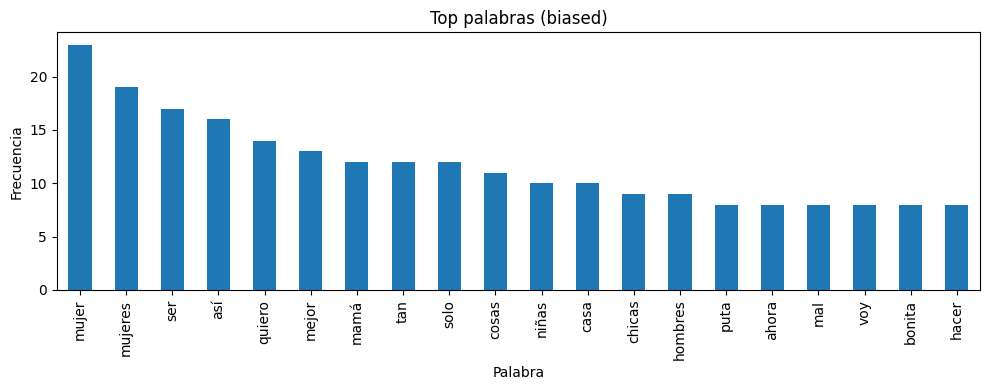

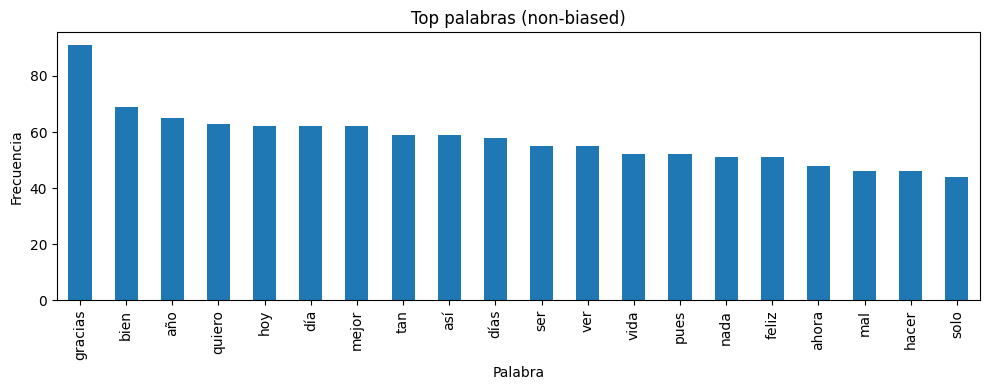

In [12]:
# Contar palabras

from collections import Counter
import pandas as pd

# Asumo que ya tienes la columna 'clean' (texto limpio) y 'Label'
def top_palabras_por_label(df, etiqueta, n=20):
    c = Counter()
    for t in df.loc[df["Label"] == etiqueta, "clean"].dropna():
        c.update(t.split())
    return pd.DataFrame(c.most_common(n), columns=["palabra", "frecuencia"])

top_biased = top_palabras_por_label(data, "biased", n=20)
top_nonbiased = top_palabras_por_label(data, "non-biased", n=20)

display(top_biased, top_nonbiased)


# Visualización de frecuencia de palabras

import matplotlib.pyplot as plt

for nombre, df_top in [("biased", top_biased), ("non-biased", top_nonbiased)]:
    ax = df_top.plot(kind="bar", x="palabra", y="frecuencia", legend=False, figsize=(10,4))
    ax.set_title(f"Top palabras ({nombre})")
    ax.set_xlabel("Palabra")
    ax.set_ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()




**Preguntas de Análisis de Frecuencia:**
- ¿Qué palabras son más comunes en los tweets 'biased' en comparación con los 'non-biased'?
- ¿Hay palabras que sugieran un sesgo en los tweets etiquetados como 'biased'?
- ¿Cómo podrían usar las empresas esta información para entender mejor las opiniones sesgadas?

## Análisis de Frecuencia — Resumen (primera persona)

### 1) ¿Qué veo en cada etiqueta?
- **biased:** observo muchas **palabras generizadas** (`mujer`, `mujeres`, `niñas`, `chicas`, `hombres`, `mamá`) y algunas **valorativas/despectivas** (`puta`, a veces `bonita`). También aparecen conectores comunes (`ser`, `así`, `quiero`, `solo`).
- **non-biased:** predominan **términos neutros y cotidianos** (`gracias`, `bien`, `hoy`, `día`, `vida`, `feliz`, `ver`, `pues`) y verbos generales (`hacer`, `ser`).

> Concluyo que el lenguaje *biased* tiende a **referirse a personas por su género** o **calificarlas**, mientras que el *non-biased* suena **conversacional y neutral**.

---

### 2) ¿Qué palabras me sugieren sesgo?
- **Señales fuertes:** `mujer`, `mujeres`, `niñas`, `chicas`, `hombres`, y términos **despectivos/sexualizantes** como `puta` (y `bonita` según el contexto).
- **Señales débiles:** conectores como `ser`, `así`, `quiero`, `solo`, `ahora`, `mal`; por sí solos **no bastan** y necesito ver su **contexto** (co-ocurrencias, n-gramas).

---

### 3) ¿Cómo usaría esto en una empresa?
- **Monitoreo:** crearía una **lista semilla** de términos sensibles para alertas y **revisión humana priorizada**.
- **Modelado:** incorporaría estas palabras y sus **n-gramas/co-ocurrencias** como *features* junto con **embeddings** para un clasificador de sesgo/hostilidad.
- **Brand safety:** **filtraría o despriorizaría** contenido con alto riesgo alrededor de campañas.
- **Inteligencia de conversación:** seguiría la **evolución temporal** de términos generizados para detectar **picos** y ajustar mensajes.
- **Políticas internas:** impulsaría **guías de lenguaje inclusivo** y flujos de **escalamiento**.

> En resumen, uso la **frecuencia** como punto de partida y confirmo con **contexto** (n-gramas, co-ocurrencias y revisión humana) para evitar falsos positivos.


## 6. Visualización con Nube de Palabras
Usamos una nube de palabras para visualizar las palabras más comunes en cada conjunto de tweets.

In [13]:
## Cree una función para generar nube de palabras

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Uso el set de stopwords definido antes (stop_es). Si no existe, creo uno básico.
try:
    _ = stop_es
except NameError:
    stop_es = {
        "de","la","que","el","en","y","a","los","del","se","las","por","un","para","con",
        "no","una","su","al","lo","como","más","pero","sus","le","ya","o","esto","sí","si",
        "porque","muy","también","me","hay","qué","cuando","todo","esta","ser","son","mi",
        "tu","te","yo","él","ella","ellos","ellas","nos","nosotros","ustedes"
    }

def plot_wordcloud(text_series, title="WordCloud", width=1100, height=450, max_words=200):
    """Genera y muestra una nube de palabras a partir de una serie de texto limpio."""
    texto = " ".join(text_series.dropna().astype(str))
    wc = WordCloud(
        width=width, height=height,
        background_color="white",
        stopwords=stop_es,
        max_words=max_words,
        collocations=False,  # evita repetir bigramas como una sola palabra
        normalize_plurals=True
    ).generate(texto)

    plt.figure(figsize=(12,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()


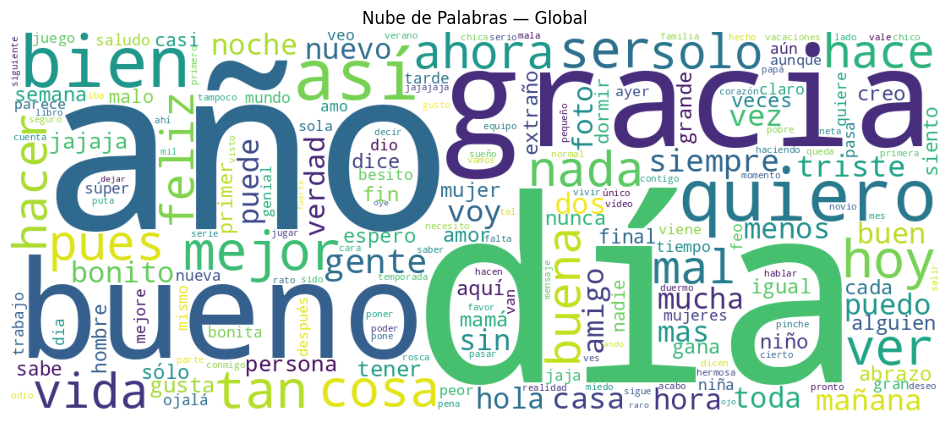

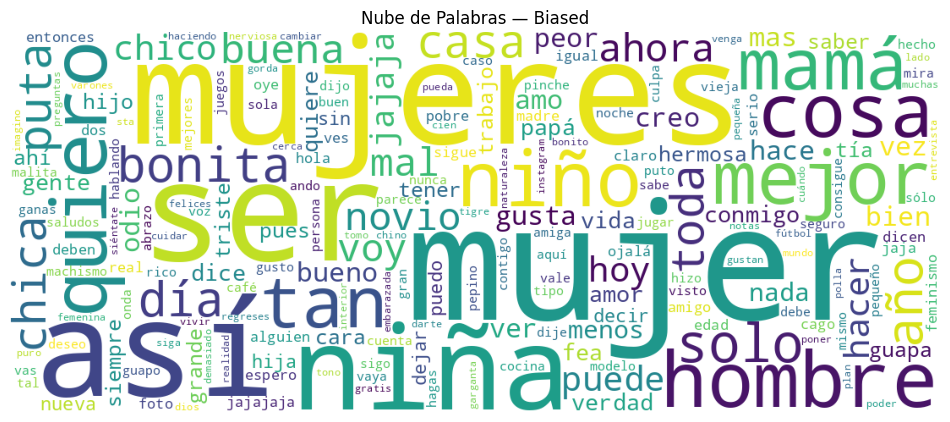

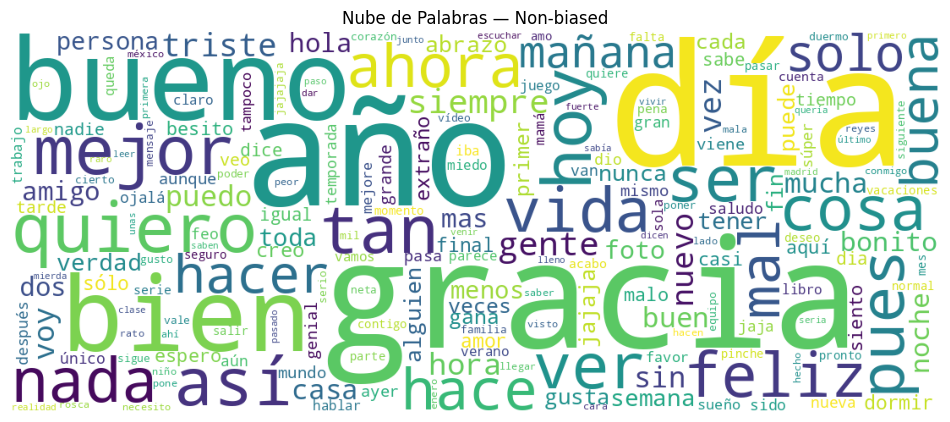

In [14]:
# Generar nube de palabras para cada conjunto

# Global (todo el dataset limpio)
plot_wordcloud(data["clean"], "Nube de Palabras — Global")

# Solo biased
plot_wordcloud(data.loc[data["Label"]=="biased", "clean"], "Nube de Palabras — Biased")

# Solo non-biased
plot_wordcloud(data.loc[data["Label"]=="non-biased", "clean"], "Nube de Palabras — Non-biased")


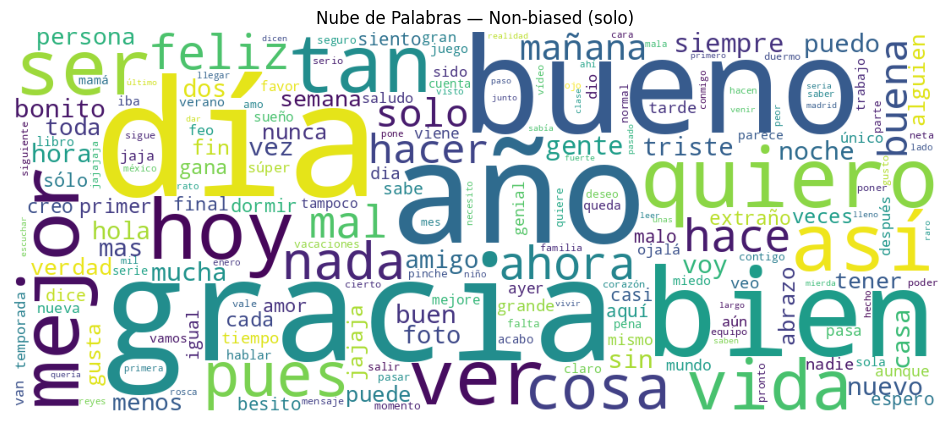

In [15]:
# NO biased nube de palabras (solo la clase non-biased, por si necesitas la celda separada)
plot_wordcloud(data.loc[data["Label"]=="non-biased", "clean"], "Nube de Palabras — Non-biased (solo)")


## 7. Conclusiones y Perspectiva de Negocios
En este taller, hemos explorado cómo el análisis de texto puede ofrecer información valiosa sobre el contenido y el sentimiento de los tweets. Reflexionemos sobre algunas preguntas de negocio:
- ¿Cómo podría utilizarse este análisis para mejorar la comunicación de la marca?
- ¿Qué ajustes se podrían hacer en una campaña de marketing si los tweets son predominantemente 'biased'?
- ¿Qué patrones importantes se podrían explorar en un análisis futuro (e.g., análisis de tendencias a lo largo del tiempo)?

## 7. Conclusiones y Perspectiva de Negocio (mi síntesis)

**Idea clave:** con la limpieza y las frecuencias vi que los *biased* concentran
términos generizados/despectivos, mientras que los *non-biased* son más neutros
y conversacionales. Esto me da señales claras para comunicación, moderación y
medición.

---

### 1) ¿Cómo uso este análisis para mejorar la comunicación de la marca?
- **Guías de lenguaje inclusivo:** actualizo el manual de estilo con ejemplos
  “sí/no” basados en los tokens detectados.
- **Respuestas tipo y entrenamiento:** preparo macros de atención y
  *playbooks* para casos con sesgo (tono empático + redirección a info útil).
- **Monitoreo proactivo:** activo alertas con una **lista semilla** (mujer,
  niñas, chicas, etc.) y priorizo revisión humana.
- **A/B testing de copys:** pruebo versiones neutras vs. emocionales y mido
  impacto en engagement y *brand safety*.
- **Segmentación y timing:** adapto mensajes por audiencia/canal y evito
  activar campañas cuando detecto picos de términos sensibles.

---

### 2) ¿Qué ajusto si predominan tweets *biased*?
- **Pauta segura:** aplico *exclusions/brand safety lists* y reduzco inversión
  en ubicaciones de riesgo; priorizo inventario verificado.
- **Creatividades y mensajes:** reviso piezas por sesgos involuntarios; cambio
  claim/visual si activa palabras gatillo.
- **Contenido correctivo:** publico piezas educativas/FAQ y vocerías que
  aclaren posturas y valores de la marca.
- **Moderación reforzada:** filtro UGC, activo “comentarios con aprobación” y
  escalo casos críticos según el playbook.
- **Influencers/aliados:** selecciono voceros confiables para reencuadrar la
  conversación.

---

### 3) ¿Qué patrones exploro a futuro?
- **Tendencias temporales:** evolución semanal de *biased* vs. *non-biased*
  alrededor de lanzamientos o crisis.
- **Co-ocurrencias y n-gramas:** combinaciones que disparan sesgo (p. ej.,
  *mujer + adjetivo X*).
- **Temas y sentimiento:** *topic modeling* + polaridad para entender drivers
  del sesgo.
- **Canales y audiencias:** comparación por plataforma, región y cohortes para
  reasignar presupuesto y esfuerzo de moderación.
- **Red de difusión:** detectar cuentas que amplifican sesgo para actuar con
  respuestas dirigidas o *deprioritization*.

> En resumen, usaré la lista de términos sensibles para **alertas y
> playbooks**, ajustaré **mensajes/pauta** según el riesgo y priorizaré
> **tendencias, co-ocurrencias y temas** para decisiones continuas.
